In [25]:
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib.dates as mdates
import numpy as np # linear algebra
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import math
from datetime import datetime, date
import warnings
warnings.filterwarnings('ignore')
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense

print("Setup Complete")

Setup Complete


In [26]:
#모델불러오기
dam = pd.read_csv('보령댐_일별.csv', encoding= 'cp949', thousands=',')
dam.head()

,일시,댐수위(ELm),강우량(mm),유입량(㎡/sec),총방류량(㎡/sec),저수량(백만㎥/sec),저수율(%)
0,2015-01-01,66.10,0.0,1.7,2.7,52.91,45.3
1,2015-01-02,66.10,1.7,2.7,2.7,52.91,45.3
2,2015-01-03,66.08,0.0,1.6,2.6,52.83,45.2
3,2015-01-04,66.06,0.0,1.7,2.7,52.74,45.1
4,2015-01-05,66.04,13.2,1.8,2.8,52.65,45.0


In [27]:
jsj = pd.read_csv('정수장.csv', encoding= 'utf-8', thousands=',')
jsj

,Date,데이터값
0,2015-01-01,188112
1,2015-01-02,182624
2,2015-01-03,182256
3,2015-01-04,185216
4,2015-01-05,178848
...,...,...
3108,2023-07-06,260224
3109,2023-07-07,258240
3110,2023-07-08,255936
3111,2023-07-09,251776


In [28]:
dam

,일시,댐수위(ELm),강우량(mm),유입량(㎡/sec),총방류량(㎡/sec),저수량(백만㎥/sec),저수율(%)
0,2015-01-01,66.10,0.0,1.7,2.7,52.91,45.30
1,2015-01-02,66.10,1.7,2.7,2.7,52.91,45.30
2,2015-01-03,66.08,0.0,1.6,2.6,52.83,45.20
3,2015-01-04,66.06,0.0,1.7,2.7,52.74,45.10
4,2015-01-05,66.04,13.2,1.8,2.8,52.65,45.00
...,...,...,...,...,...,...,...
3118,2023-07-16,69.59,2.1,38.8,113.7,65.97,56.44
3119,2023-07-17,69.75,34.6,31.7,23.2,66.71,57.07
3120,2023-07-18,70.58,59.1,98.2,53.2,70.60,60.40
3121,2023-07-19,70.79,0.0,45.8,33.9,71.63,61.27


In [29]:
dam.columns = ['date', 'water_level', 'rainfall', 'inflow', 'outflow', 'storage', 'storage_rate']
dam.head()

,date,water_level,rainfall,inflow,outflow,storage,storage_rate
0,2015-01-01,66.10,0.0,1.7,2.7,52.91,45.3
1,2015-01-02,66.10,1.7,2.7,2.7,52.91,45.3
2,2015-01-03,66.08,0.0,1.6,2.6,52.83,45.2
3,2015-01-04,66.06,0.0,1.7,2.7,52.74,45.1
4,2015-01-05,66.04,13.2,1.8,2.8,52.65,45.0


In [30]:
#결측값 확인
print(dam.isnull().sum())

date            0
water_level     0
rainfall        3
inflow          0
outflow         0
storage         0
storage_rate    0
dtype: int64


In [31]:
dam=dam.interpolate()

In [32]:
#숫자로 변환 (필요할 경우 사용)
dam['inflow'] = pd.to_numeric(dam['inflow'],errors='coerce')

In [33]:
dam.describe()

,water_level,rainfall,inflow,outflow,storage,storage_rate
count,3123.000000,3123.000000,3123.000000,3123.000000,3123.000000,3123.000000
mean,63.836513,3.747102,3.957829,3.880179,44.497528,38.068655
std,4.468232,14.417918,15.275968,11.291775,17.339779,14.833018
min,52.160000,0.000000,0.000000,1.600000,9.690000,8.300000
25%,61.080000,0.000000,0.700000,2.700000,32.880000,28.110000
50%,63.130000,0.000000,1.500000,3.100000,40.300000,34.500000
75%,65.915000,0.400000,2.700000,3.400000,51.870000,44.400000
max,73.910000,293.000000,476.400000,535.900000,88.220000,75.500000


In [34]:
dam = dam.reset_index(drop=True)

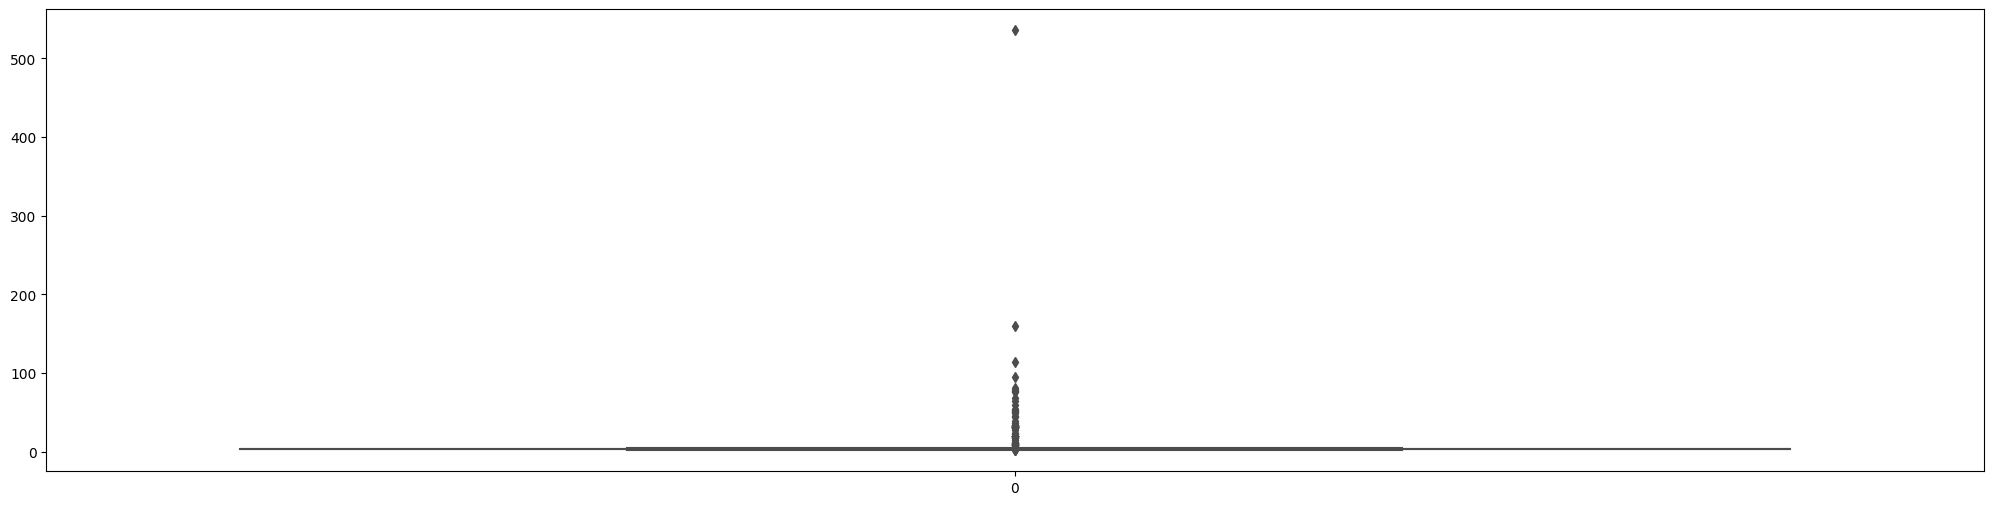

In [35]:
plt.figure(figsize=(25,6))
sns.boxplot(data=dam['outflow'], color='red')
plt.show()

In [36]:
#remove outlier

Q1 = dam['outflow'].quantile(0.25)
Q3 = dam['outflow'].quantile(0.75)
IQR = Q3 - Q1    #IQR is interquartile range.

filter = (dam['outflow'] >= Q1 - 1.5 * IQR) & (dam['outflow'] <= Q3 + 1.5 *IQR)
dam = dam.loc[filter]
print(dam['outflow'].describe())
print('\n')
print(dam['outflow'].describe())

count    3051.000000
mean        3.047886
std         0.486329
min         1.700000
25%         2.700000
50%         3.100000
75%         3.400000
max         4.400000
Name: outflow, dtype: float64


count    3051.000000
mean        3.047886
std         0.486329
min         1.700000
25%         2.700000
50%         3.100000
75%         3.400000
max         4.400000
Name: outflow, dtype: float64


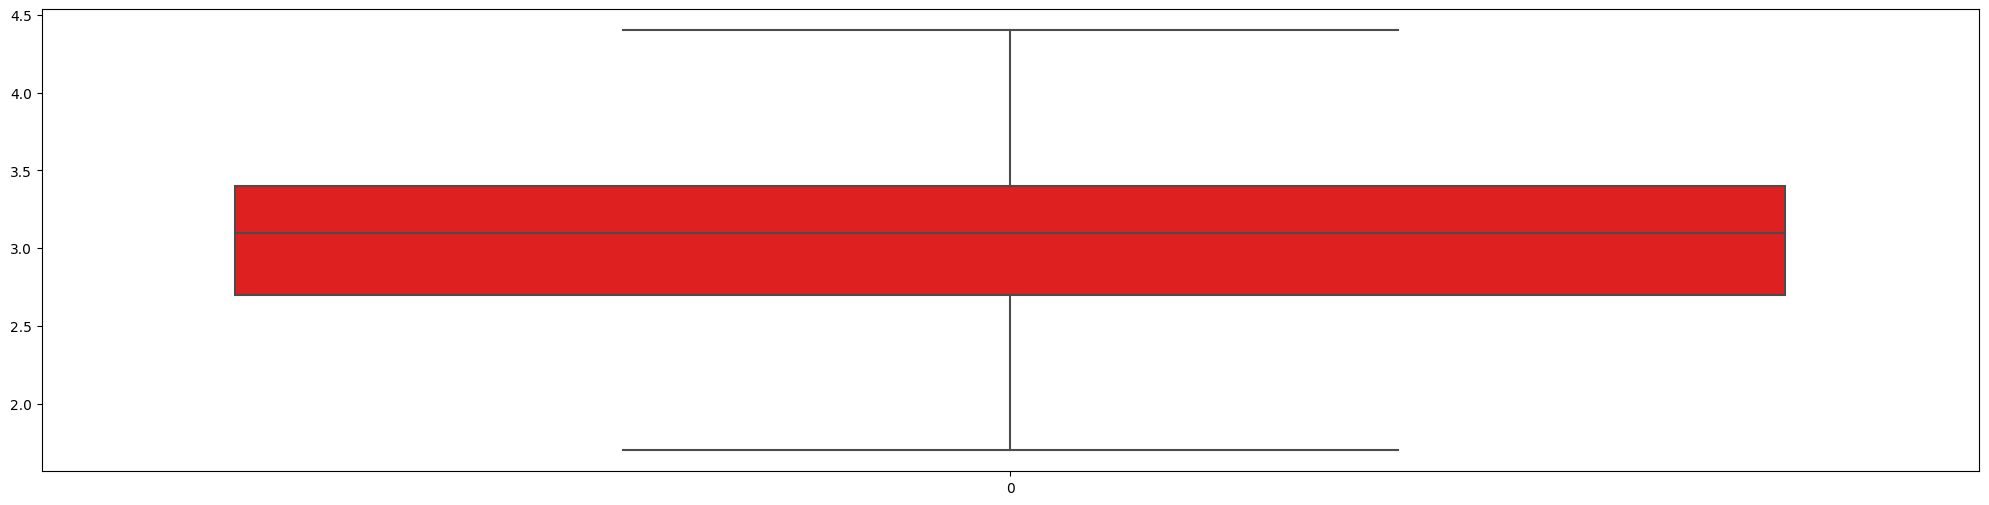

In [37]:
plt.figure(figsize=(25,6))
sns.boxplot(data=dam['outflow'], color='red')
plt.show()

In [38]:
dam = dam.reset_index(drop=True)

In [39]:
# dam["date"] = pd.to_datetime(dam["date"])
# dam.index = dam["date"]

In [40]:
dam.head()

,date,water_level,rainfall,inflow,outflow,storage,storage_rate
0,2015-01-01,66.10,0.0,1.7,2.7,52.91,45.3
1,2015-01-02,66.10,1.7,2.7,2.7,52.91,45.3
2,2015-01-03,66.08,0.0,1.6,2.6,52.83,45.2
3,2015-01-04,66.06,0.0,1.7,2.7,52.74,45.1
4,2015-01-05,66.04,13.2,1.8,2.8,52.65,45.0


In [41]:
dam

,date,water_level,rainfall,inflow,outflow,storage,storage_rate
0,2015-01-01,66.10,0.0,1.7,2.7,52.91,45.30
1,2015-01-02,66.10,1.7,2.7,2.7,52.91,45.30
2,2015-01-03,66.08,0.0,1.6,2.6,52.83,45.20
3,2015-01-04,66.06,0.0,1.7,2.7,52.74,45.10
4,2015-01-05,66.04,13.2,1.8,2.8,52.65,45.00
...,...,...,...,...,...,...,...
3046,2023-07-06,65.35,0.0,18.5,3.2,48.06,41.12
3047,2023-07-07,66.05,57.8,35.3,3.2,50.84,43.49
3048,2023-07-08,66.68,0.0,32.6,3.2,53.38,45.66
3049,2023-07-09,66.94,0.0,15.3,3.2,54.42,46.56


In [42]:
jsj = jsj.rename(columns={
    'Date': 'date',
    '데이터값': 'jsj_flow'
})

In [45]:
jsj

,date,jsj_flow
0,2015-01-01,188112
1,2015-01-02,182624
2,2015-01-03,182256
3,2015-01-04,185216
4,2015-01-05,178848
...,...,...
3108,2023-07-06,260224
3109,2023-07-07,258240
3110,2023-07-08,255936
3111,2023-07-09,251776


In [50]:
dam = dam.merge(jsj[['date', 'jsj_flow']], on='date', how='left')

In [51]:
dam

,date,water_level,rainfall,inflow,outflow,storage,storage_rate,jsj_flow
0,2015-01-01,66.10,0.0,1.7,2.7,52.91,45.30,188112
1,2015-01-02,66.10,1.7,2.7,2.7,52.91,45.30,182624
2,2015-01-03,66.08,0.0,1.6,2.6,52.83,45.20,182256
3,2015-01-04,66.06,0.0,1.7,2.7,52.74,45.10,185216
4,2015-01-05,66.04,13.2,1.8,2.8,52.65,45.00,178848
...,...,...,...,...,...,...,...,...
3046,2023-07-06,65.35,0.0,18.5,3.2,48.06,41.12,260224
3047,2023-07-07,66.05,57.8,35.3,3.2,50.84,43.49,258240
3048,2023-07-08,66.68,0.0,32.6,3.2,53.38,45.66,255936
3049,2023-07-09,66.94,0.0,15.3,3.2,54.42,46.56,251776


In [52]:
features = dam[['rainfall', 'inflow', 'outflow', 'storage', 'storage_rate', 'jsj_flow']]
print(features)

      rainfall  inflow  outflow  storage  storage_rate  jsj_flow
0          0.0     1.7      2.7    52.91         45.30    188112
1          1.7     2.7      2.7    52.91         45.30    182624
2          0.0     1.6      2.6    52.83         45.20    182256
3          0.0     1.7      2.7    52.74         45.10    185216
4         13.2     1.8      2.8    52.65         45.00    178848
...        ...     ...      ...      ...           ...       ...
3046       0.0    18.5      3.2    48.06         41.12    260224
3047      57.8    35.3      3.2    50.84         43.49    258240
3048       0.0    32.6      3.2    53.38         45.66    255936
3049       0.0    15.3      3.2    54.42         46.56    251776
3050       8.5    11.3      3.2    55.13         47.16    249664

[3051 rows x 6 columns]


In [53]:
from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler()
scaler.fit(features)
dam_scaled=scaler.transform(features)

dam_scaled=pd.DataFrame(data=dam_scaled, columns=list(features))
print('feature 최솟값')
print(dam_scaled.min())
print('\n''fearure 최댓값')
print(dam_scaled.max())

feature 최솟값
rainfall        0.0
inflow          0.0
outflow         0.0
storage         0.0
storage_rate    0.0
jsj_flow        0.0
dtype: float64

fearure 최댓값
rainfall        1.0
inflow          1.0
outflow         1.0
storage         1.0
storage_rate    1.0
jsj_flow        1.0
dtype: float64


In [54]:
dam['variation'] = 0
for i, idx in enumerate(dam.index):
    dam.loc[idx, 'variation'] = dam_scaled['rainfall'][i]+dam_scaled['inflow'][i]-dam_scaled['outflow'][i]

In [55]:
dam_scaled

,rainfall,inflow,outflow,storage,storage_rate,jsj_flow
0,0.000000,0.006781,0.370370,0.559845,0.560606,0.228393
1,0.007482,0.010770,0.370370,0.559845,0.560606,0.211814
2,0.000000,0.006382,0.333333,0.558808,0.559091,0.210702
3,0.000000,0.006781,0.370370,0.557642,0.557576,0.219644
4,0.058099,0.007180,0.407407,0.556477,0.556061,0.200406
...,...,...,...,...,...,...
3046,0.000000,0.073793,0.555556,0.497021,0.497273,0.446249
3047,0.254401,0.140806,0.555556,0.533031,0.533182,0.440255
3048,0.000000,0.130036,0.555556,0.565933,0.566061,0.433295
3049,0.000000,0.061029,0.555556,0.579404,0.579697,0.420727


In [56]:
dam = dam.reset_index(drop=True)

In [57]:
df = dam['variation']
df

0      -0.363589
1      -0.352118
2      -0.326951
3      -0.363589
4      -0.342129
          ...   
3046   -0.481762
3047   -0.160348
3048   -0.425520
3049   -0.494526
3050   -0.473070
Name: variation, Length: 3051, dtype: float64

In [58]:
ds_list = []

for i in range(1,len(df)):
    ds = df[i]-df[i-1]
    ds_list.append(ds)

ds_dt = pd.DataFrame(ds_list)

In [59]:
ds_dt.columns = ['ds_dt']
print(ds_dt)

         ds_dt
0     0.011471
1     0.025167
2    -0.036638
3     0.021460
4     0.006557
...        ...
3045 -0.250354
3046  0.321414
3047 -0.265171
3048 -0.069007
3049  0.021457

[3050 rows x 1 columns]


In [60]:
ds_dt['ds_dt'] = pd.to_numeric(ds_dt['ds_dt'],errors='coerce')
print(ds_dt)

         ds_dt
0     0.011471
1     0.025167
2    -0.036638
3     0.021460
4     0.006557
...        ...
3045 -0.250354
3046  0.321414
3047 -0.265171
3048 -0.069007
3049  0.021457

[3050 rows x 1 columns]


In [61]:
dam = dam[1:]

In [62]:
dam_scaled = dam_scaled[1:]

In [64]:
dam = dam.reset_index(drop=True)
print(dam)

            date  water_level  rainfall  inflow  outflow  storage  \
0     2015-01-02        66.10       1.7     2.7      2.7    52.91   
1     2015-01-03        66.08       0.0     1.6      2.6    52.83   
2     2015-01-04        66.06       0.0     1.7      2.7    52.74   
3     2015-01-05        66.04      13.2     1.8      2.8    52.65   
4     2015-01-06        66.07       4.1     4.2      2.7    52.78   
...          ...          ...       ...     ...      ...      ...   
3045  2023-07-06        65.35       0.0    18.5      3.2    48.06   
3046  2023-07-07        66.05      57.8    35.3      3.2    50.84   
3047  2023-07-08        66.68       0.0    32.6      3.2    53.38   
3048  2023-07-09        66.94       0.0    15.3      3.2    54.42   
3049  2023-07-10        67.11       8.5    11.3      3.2    55.13   

      storage_rate  jsj_flow  variation  
0            45.30    182624  -0.352118  
1            45.20    182256  -0.326951  
2            45.10    185216  -0.363589  
3  

In [65]:
dam_scaled = dam_scaled.reset_index(drop=True)
print(dam_scaled)

      rainfall    inflow   outflow   storage  storage_rate  jsj_flow
0     0.007482  0.010770  0.370370  0.559845      0.560606  0.211814
1     0.000000  0.006382  0.333333  0.558808      0.559091  0.210702
2     0.000000  0.006781  0.370370  0.557642      0.557576  0.219644
3     0.058099  0.007180  0.407407  0.556477      0.556061  0.200406
4     0.018046  0.016753  0.370370  0.558161      0.559091  0.260247
...        ...       ...       ...       ...           ...       ...
3045  0.000000  0.073793  0.555556  0.497021      0.497273  0.446249
3046  0.254401  0.140806  0.555556  0.533031      0.533182  0.440255
3047  0.000000  0.130036  0.555556  0.565933      0.566061  0.433295
3048  0.000000  0.061029  0.555556  0.579404      0.579697  0.420727
3049  0.037412  0.045074  0.555556  0.588601      0.588788  0.414346

[3050 rows x 6 columns]


In [66]:
dam['ds_dt'] = ds_dt

In [67]:
dam_scaled['ds_dt'] = ds_dt
dam_scaled['obs_storage_rate'] = dam['storage_rate']

In [68]:
print(dam)

            date  water_level  rainfall  inflow  outflow  storage  \
0     2015-01-02        66.10       1.7     2.7      2.7    52.91   
1     2015-01-03        66.08       0.0     1.6      2.6    52.83   
2     2015-01-04        66.06       0.0     1.7      2.7    52.74   
3     2015-01-05        66.04      13.2     1.8      2.8    52.65   
4     2015-01-06        66.07       4.1     4.2      2.7    52.78   
...          ...          ...       ...     ...      ...      ...   
3045  2023-07-06        65.35       0.0    18.5      3.2    48.06   
3046  2023-07-07        66.05      57.8    35.3      3.2    50.84   
3047  2023-07-08        66.68       0.0    32.6      3.2    53.38   
3048  2023-07-09        66.94       0.0    15.3      3.2    54.42   
3049  2023-07-10        67.11       8.5    11.3      3.2    55.13   

      storage_rate  jsj_flow  variation     ds_dt  
0            45.30    182624  -0.352118  0.011471  
1            45.20    182256  -0.326951  0.025167  
2            45

In [69]:
print(dam_scaled)

      rainfall    inflow   outflow   storage  storage_rate  jsj_flow  \
0     0.007482  0.010770  0.370370  0.559845      0.560606  0.211814   
1     0.000000  0.006382  0.333333  0.558808      0.559091  0.210702   
2     0.000000  0.006781  0.370370  0.557642      0.557576  0.219644   
3     0.058099  0.007180  0.407407  0.556477      0.556061  0.200406   
4     0.018046  0.016753  0.370370  0.558161      0.559091  0.260247   
...        ...       ...       ...       ...           ...       ...   
3045  0.000000  0.073793  0.555556  0.497021      0.497273  0.446249   
3046  0.254401  0.140806  0.555556  0.533031      0.533182  0.440255   
3047  0.000000  0.130036  0.555556  0.565933      0.566061  0.433295   
3048  0.000000  0.061029  0.555556  0.579404      0.579697  0.420727   
3049  0.037412  0.045074  0.555556  0.588601      0.588788  0.414346   

         ds_dt  obs_storage_rate  
0     0.011471             45.30  
1     0.025167             45.20  
2    -0.036638             45.

In [70]:
dam_scaled.insert(0, 'date', dam['date'])

In [71]:
dam_scaled["date"] = pd.to_datetime(dam_scaled["date"])

In [72]:
dam_scaled

,date,rainfall,inflow,outflow,storage,storage_rate,jsj_flow,ds_dt,obs_storage_rate
0,2015-01-02,0.007482,0.010770,0.370370,0.559845,0.560606,0.211814,0.011471,45.30
1,2015-01-03,0.000000,0.006382,0.333333,0.558808,0.559091,0.210702,0.025167,45.20
2,2015-01-04,0.000000,0.006781,0.370370,0.557642,0.557576,0.219644,-0.036638,45.10
3,2015-01-05,0.058099,0.007180,0.407407,0.556477,0.556061,0.200406,0.021460,45.00
4,2015-01-06,0.018046,0.016753,0.370370,0.558161,0.559091,0.260247,0.006557,45.20
...,...,...,...,...,...,...,...,...,...
3045,2023-07-06,0.000000,0.073793,0.555556,0.497021,0.497273,0.446249,-0.250354,41.12
3046,2023-07-07,0.254401,0.140806,0.555556,0.533031,0.533182,0.440255,0.321414,43.49
3047,2023-07-08,0.000000,0.130036,0.555556,0.565933,0.566061,0.433295,-0.265171,45.66
3048,2023-07-09,0.000000,0.061029,0.555556,0.579404,0.579697,0.420727,-0.069007,46.56


In [73]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [74]:
# 2. SMAPE 함수 정의
def smape(A, F):
    return 100 * np.mean(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [75]:
# 3. 데이터 준비 및 처리

# 가정: dam_scaled는 이미 정의된 DataFrame이며, 필요한 column들이 존재합니다.
features = ["rainfall", "inflow", "outflow", "ds_dt", "jsj_flow"]
output = "obs_storage_rate"

In [76]:
X = dam_scaled[features]
y = dam_scaled[output]

In [104]:
split_index = int(len(X) * 0.80)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

In [105]:
# 가정: dam_scaled에 'date'라는 이름의 날짜 column이 있습니다.
prophet_data_train = dam_scaled[['date', 'obs_storage_rate']][:split_index]
prophet_data_test = dam_scaled[['date', 'obs_storage_rate']][split_index:]

prophet_data_train.columns = ['ds', 'y']
prophet_data_test.columns = ['ds', 'y']

In [106]:
print(X_test.shape)

(610, 5)


### obs_storage_rate만 사용했을 때

DEBUG:cmdstanpy:input tempfile: /tmp/tmplbcfg5a8/0ocuxa_v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplbcfg5a8/fdbzpcma.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32186', 'data', 'file=/tmp/tmplbcfg5a8/0ocuxa_v.json', 'init=/tmp/tmplbcfg5a8/fdbzpcma.json', 'output', 'file=/tmp/tmplbcfg5a8/prophet_modely1h9c4mo/prophet_model-20230811093357.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:33:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:33:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplbcfg5a8/810wrnaf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplbcfg5a8/4xi2glnw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Best changepoint_prior_scale: 0.03
SMAPE for Prophet with best scale: 16.874121092925805


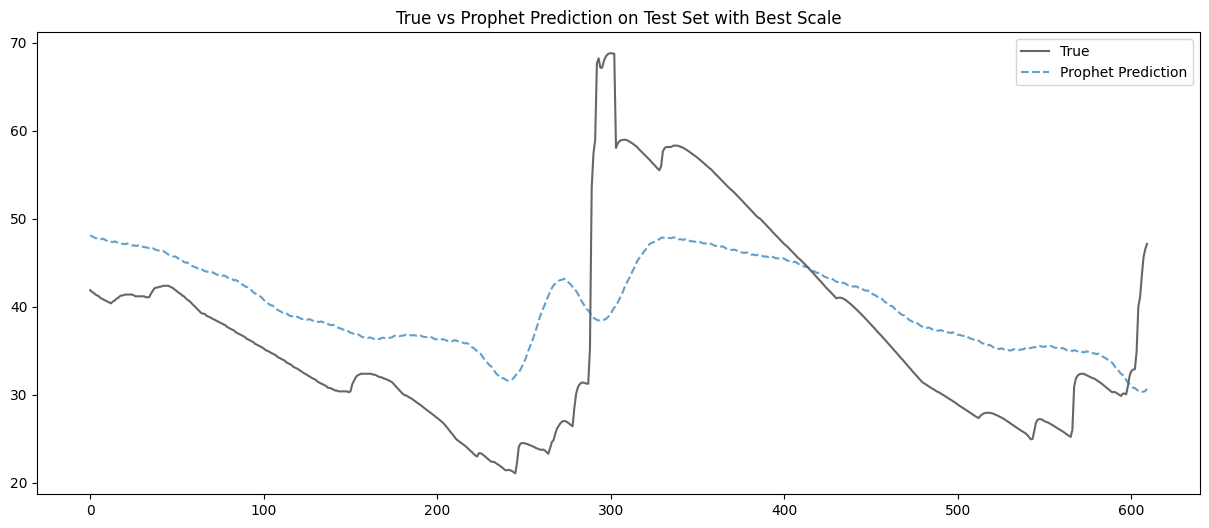

In [107]:
# 가정: dam_scaled에 'date'라는 이름의 날짜 column이 있습니다.
prophet_data_train = dam_scaled[['date', 'obs_storage_rate']][:split_index]
prophet_data_test = dam_scaled[['date', 'obs_storage_rate']][split_index:]

prophet_data_train.columns = ['ds', 'y']
prophet_data_test.columns = ['ds', 'y']

from prophet import Prophet

# 후보 changepoint_prior_scale 값들 정의
candidate_scales = [0.01,0.02,0.03,0.04,0.05,0.075,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
best_smape = float('inf')
best_scale = 0.1  # 초기값 설정

# Grid search 수행
for scale in candidate_scales:
    # Prophet 모델 초기화 및 학습
    model = Prophet(changepoint_prior_scale=scale, daily_seasonality = True)
    model.fit(prophet_data_train)

    # 미래 데이터 프레임 생성 및 예측
    future = model.make_future_dataframe(periods=len(prophet_data_test))
    forecast = model.predict(future)
    y_pred = forecast['yhat'][split_index:].values

    # SMAPE 계산
    current_smape = smape(prophet_data_test['y'], y_pred)
    if current_smape < best_smape:
        best_smape = current_smape
        best_scale = scale

# 최적의 changepoint_prior_scale 값으로 모델 초기화 및 학습
model_prophet = Prophet(changepoint_prior_scale=best_scale)
model_prophet.fit(prophet_data_train)

# 미래 데이터 프레임 생성 및 예측
future = model_prophet.make_future_dataframe(periods=len(prophet_data_test))
forecast = model_prophet.predict(future)
y_pred_prophet = forecast['yhat'][split_index:].values

# 결과 출력
print(f"Best changepoint_prior_scale: {best_scale}")
print(f"SMAPE for Prophet with best scale: {best_smape}")

# 그래프로 표현
plt.figure(figsize=(15, 6))
plt.plot(prophet_data_test['y'].values, label='True', color='black', alpha=0.6)
plt.plot(y_pred_prophet, label='Prophet Prediction', linestyle='dashed', alpha=0.7)
plt.title("True vs Prophet Prediction on Test Set with Best Scale")
plt.legend()
plt.show()

DEBUG:cmdstanpy:input tempfile: /tmp/tmplbcfg5a8/rvswp4l2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplbcfg5a8/6jw5cipz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66852', 'data', 'file=/tmp/tmplbcfg5a8/rvswp4l2.json', 'init=/tmp/tmplbcfg5a8/6jw5cipz.json', 'output', 'file=/tmp/tmplbcfg5a8/prophet_modelr5s9hh2q/prophet_model-20230811093438.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:34:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:34:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplbcfg5a8/515eni98.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplbcfg5a8/raty179t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Best changepoint_prior_scale: 0.04
SMAPE for Prophet with best scale: 15.135445037141679


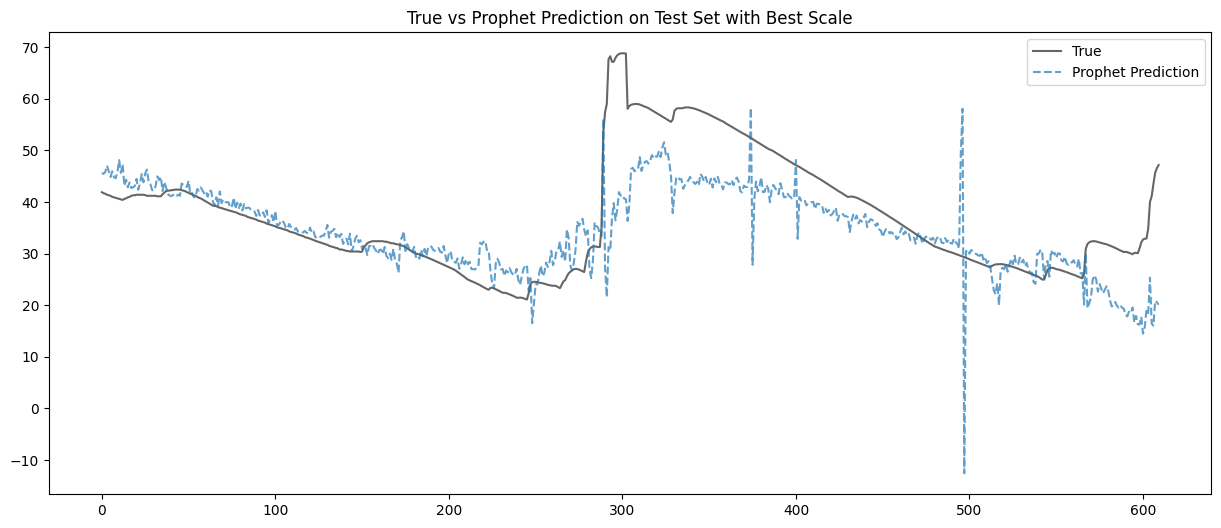

In [108]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

# train, test 데이터 준비
prophet_data_train = dam_scaled[['date', 'obs_storage_rate']][:split_index]
prophet_data_test = dam_scaled[['date', 'obs_storage_rate']][split_index:]
prophet_data_train.columns = ['ds', 'y']
prophet_data_test.columns = ['ds', 'y']

# 기타 feature들을 train과 test 데이터셋에 추가
for col in dam_scaled.columns:
    if col not in ['date', 'obs_storage_rate', 'storage_rate', 'storage']:
        prophet_data_train[col] = dam_scaled[col][:split_index]
        prophet_data_test[col] = dam_scaled[col][split_index:]

# 후보 changepoint_prior_scale 값들 정의 및 초기 설정
candidate_scales = [0.01, 0.02, 0.03, 0.04, 0.05, 0.075, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
best_smape = float('inf')
best_scale = 0.1

for scale in candidate_scales:
    model = Prophet(changepoint_prior_scale=scale, daily_seasonality=True)

    # 추가적인 feature들을 Prophet 모델에 추가
    for col in dam_scaled.columns:
        if col not in ['date', 'obs_storage_rate', 'storage_rate', 'storage']:
            model.add_regressor(col)

    model.fit(prophet_data_train)

    # 예측을 위한 future 데이터 프레임 생성
    future_with_features = prophet_data_test.drop('y', axis=1)

    # 예측
    forecast = model.predict(future_with_features)
    y_pred = forecast['yhat'].values

    # SMAPE 계산
    current_smape = smape(prophet_data_test['y'], y_pred)
    if current_smape < best_smape:
        best_smape = current_smape
        best_scale = scale

# 최적의 changepoint_prior_scale로 모델 학습
model_prophet = Prophet(changepoint_prior_scale=best_scale)
for col in dam_scaled.columns:
    if col not in ['date', 'obs_storage_rate', 'storage_rate', 'storage']:
        model_prophet.add_regressor(col)
model_prophet.fit(prophet_data_train)

# 예측을 위한 future 데이터 프레임 생성
future_with_features = prophet_data_test.drop('y', axis=1)

# 예측
forecast = model_prophet.predict(future_with_features)
y_pred_prophet = forecast['yhat'].values

# 결과 출력 및 그래프 표현
print(f"Best changepoint_prior_scale: {best_scale}")
print(f"SMAPE for Prophet with best scale: {best_smape}")

plt.figure(figsize=(15, 6))
plt.plot(prophet_data_test['y'].values, label='True', color='black', alpha=0.6)
plt.plot(y_pred_prophet, label='Prophet Prediction', linestyle='dashed', alpha=0.7)
plt.title("True vs Prophet Prediction on Test Set with Best Scale")
plt.legend()
plt.show()


In [114]:
alphas = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,0.19, 0.2, 0.3, 0.4,0.41,0.42,0.43,0.44,0.45,0.46,0.47,0.48,0.49, 0.5,0.51,0.52,0.53,0.54,0.55,0.56,0.57,0.58,0.59, 0.6, 0.7, 0.8, 0.9, 1.0]
best_smape_ewm = float('inf')
best_alpha = None

for alpha in alphas:
    y_pred_ewm = pd.Series(y_pred_prophet).ewm(alpha=alpha).mean().values
    current_smape_ewm = smape(prophet_data_test['y'].values, y_pred_ewm)

    if current_smape_ewm < best_smape_ewm:
        best_smape_ewm = current_smape_ewm
        best_alpha = alpha

print(f"Best alpha: {best_alpha}")
print(f"SMAPE for EWMA Prophet Prediction with best alpha: {best_smape_ewm}")

Best alpha: 0.12
SMAPE for EWMA Prophet Prediction with best alpha: 14.309405325107152


SMAPE for Prophet with best scale: 14.309405325107152


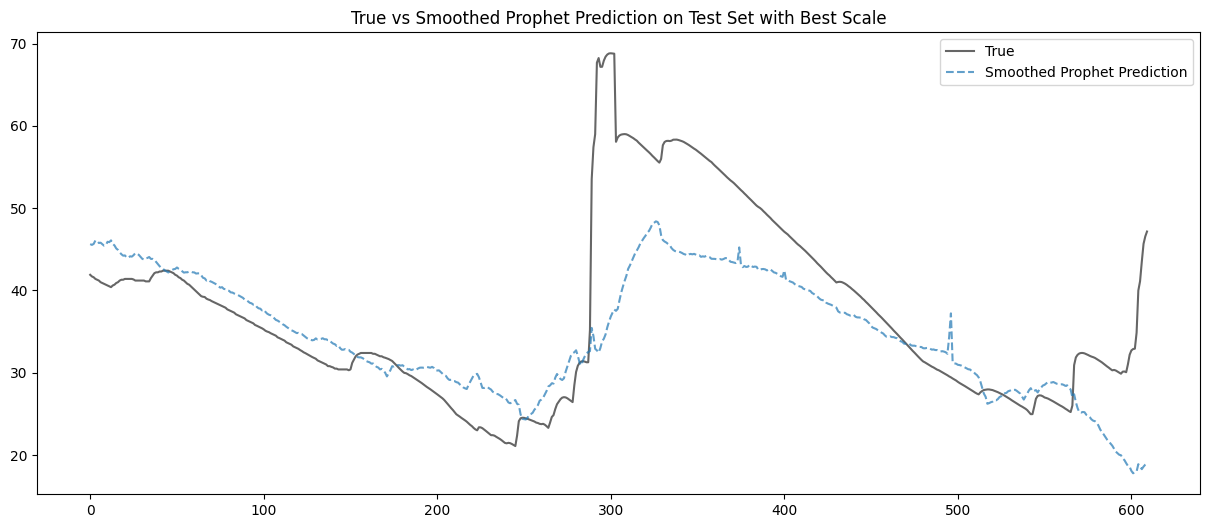

In [115]:
alpha = best_alpha # 지수 가중치. 0과 1 사이의 값을 가집니다. 값이 작을수록 평활화 정도가 커집니다.

y_pred_ewm = pd.Series(y_pred_prophet).ewm(alpha=alpha).mean().values

smape_ewm = smape(prophet_data_test['y'].values, y_pred_ewm)

# 결과 출력 및 그래프 표현
print(f"SMAPE for Prophet with best scale: {smape_ewm}")

plt.figure(figsize=(15, 6))
plt.plot(prophet_data_test['y'].values, label='True', color='black', alpha=0.6)
plt.plot(y_pred_ewm, label='Smoothed Prophet Prediction', linestyle='dashed', alpha=0.7)
plt.title("True vs Smoothed Prophet Prediction on Test Set with Best Scale")
plt.legend()
plt.show()

In [116]:
from sklearn.metrics import mean_squared_error, r2_score

def smape(y_true, y_pred):
    return 100 * (2 * abs(y_pred - y_true).sum() / (abs(y_true).sum() + abs(y_pred).sum()))

def compute_rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

def compute_r2(y_true, y_pred):
    return r2_score(y_true, y_pred)


- 원래 데이터

In [121]:
y_true = prophet_data_test['y'].values

rmse_value = compute_rmse(y_true, y_pred_prophet)
smape_value = smape(y_true, y_pred_prophet)
r2_value = compute_r2(y_true, y_pred_prophet)

print(f"RMSE: {rmse_value}")
print(f"SMAPE: {smape_value}")
print(f"R^2: {r2_value}")


RMSE: 8.263605074555267
SMAPE: 15.15782061088981
R^2: 0.4356144903743545


- smooth하게 만들어 줬을때

In [122]:
y_true = prophet_data_test['y'].values

rmse_value = compute_rmse(y_true, y_pred_ewm)
smape_value = smape(y_true, y_pred_ewm)
r2_value = compute_r2(y_true, y_pred_ewm)

print(f"RMSE: {rmse_value}")
print(f"SMAPE: {smape_value}")
print(f"R^2: {r2_value}")

RMSE: 7.88303661067595
SMAPE: 14.309405325107152
R^2: 0.4864013959961502
